In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import tensorflow as tf

from keras.api.utils import to_categorical
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.api.regularizers import L2
from keras.api.callbacks import EarlyStopping
from keras.api import optimizers

In [8]:
def retrieve_data():
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }

        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    xdata = train_df.drop(columns=['target'])
    ydata = train_df["target"]

    return train_test_split(xdata, ydata, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
print(f'X_train:{X_train}')
print(f'X_test:{X_test}')
print(f'y_train:{y_train}')
print(f'y_test:{y_test}')
all_keys = y_train.unique()

X_train:          0.0     21.0     21.6      23.3      27.3  27.400000000000002  \
1745   0.3821   0.6020   1.1651    1.1881    1.6533              0.0609   
4554  16.4461  77.0424  45.8067  148.4486   91.1706            194.8146   
1452   5.2831   9.6379  11.5327    4.6804    9.3933              3.1902   
101   13.3575   4.3779  16.5216   13.1998  100.5560             35.4116   
319   26.1447  33.0404  75.1412   56.5023   85.5057            129.0202   
...       ...      ...      ...       ...       ...                 ...   
5734   0.2891   0.1832   0.6142    0.6049    0.1375              0.6321   
5191  15.4402  15.7248   3.6220    7.6753   14.2963             25.6222   
5390   5.6634  10.8871  32.8678   37.7118   20.8643             41.8496   
860   31.7260  51.8988  31.1563   31.6033   39.4191             56.3319   
7270   0.3202  29.6564  37.8924   80.6121   21.5125             61.0428   

          27.5  28.900000000000002     29.1  29.200000000000003  ...   1055.4  \
1745    0.

In [5]:
test_pca = PCA()
test_pca.fit(X_train)

PCA()

(0.0, 400.0)

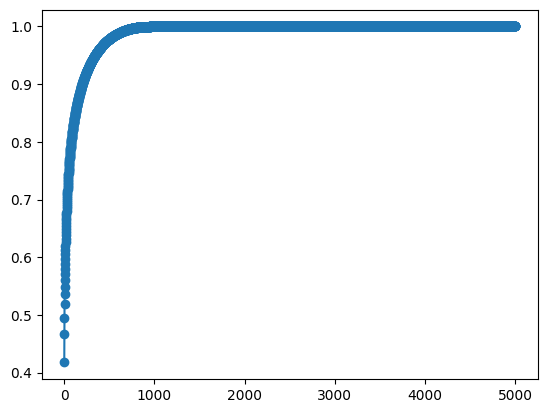

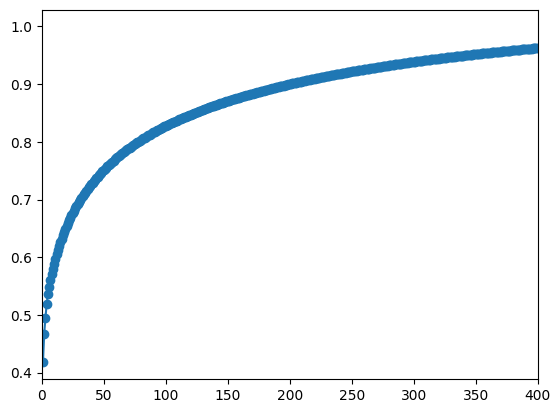

In [6]:
# Visualize
plt.figure(0)
plt.plot(range(1, X_train.shape[1] + 1), test_pca.explained_variance_ratio_.cumsum(), marker="o")
plt.figure(1)
plt.plot(range(1, X_train.shape[1] + 1), test_pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlim([0, 400])

### Machine Learning Approach _:
### Shallow Feed-Forward Classification Neural Network

In [9]:
NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest = normalize(X_test)
ytest = y_test

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 5000), Y Train Shape: (11808, 24)
X Val Shape: (1576, 5000), Y Val Shape: (1576, 24)
X Test Shape: (1970, 5000), Y Test Shape: (1970, 24)


In [64]:
l2_reg = 0.0005
def neural_network_train():
    layers = [
        Flatten(),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dropout(0.1),
        Dense(NUM_CLASSES, activation="softmax")
    ]

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model = Sequential(layers)
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['acc'])
    history = model.fit(xtrain,
                        ytrain_1hot,
                        batch_size=128,
                        epochs=500,
                        validation_data=(xval, yval_1hot),
                        callbacks=[early_stop])

    return model, history

nn_model, nn_history = neural_network_train()

Epoch 1/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0775 - loss: 3.2074 - val_acc: 0.1961 - val_loss: 3.1685
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1574 - loss: 3.1534 - val_acc: 0.1992 - val_loss: 3.0989
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1759 - loss: 3.0799 - val_acc: 0.2278 - val_loss: 3.0154
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1830 - loss: 2.9928 - val_acc: 0.2392 - val_loss: 2.9137
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1954 - loss: 2.8983 - val_acc: 0.2468 - val_loss: 2.8062
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2095 - loss: 2.7891 - val_acc: 0.2773 - val_loss: 2.6977
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2310 - loss: 2.6909 - val_acc: 0.3192 - val_loss: 2.5910
Epoch 8/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2652 - loss: 2.5874 - val_acc: 0.3598 - val_loss: 2.4844
Epoch 9/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2900

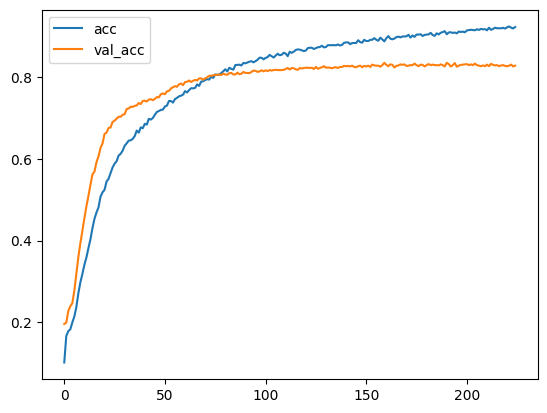

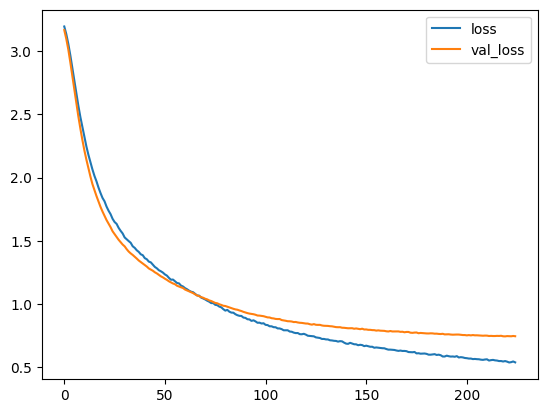

In [65]:
plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [66]:
nn_model.evaluate(xtest, ytest_1hot)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - acc: 0.8114 - loss: 0.8078


[0.79056715965271, 0.8116751313209534]